# Excel Sheet Reconciliation Assignment

# Financial Data Matching and Subset Sum Analysis

In [188]:
#pip install rapidfuzz

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import os
import itertools
import time
import warnings
import random
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from rapidfuzz import fuzz, process

Phase 1:  Data Preparation and Exploration

1.1 : Load and Examine Data

In [190]:
transaction_source_path="/content/KH_Bank.XLSX"
target_amount_path="/content/Customer_Ledger_Entries_FULL.xlsx"


In [191]:
def load_data():
  sheet_1_transcation=pd.read_excel(transaction_source_path)
  sheet_2_target_amount=pd.read_excel(target_amount_path)

  #display
  print("Complete Loading Data .......")

  return sheet_1_transcation,sheet_2_target_amount

1.2: Data Preparation

In [192]:
def data_preparation(sheet_1_transcation,sheet_2_target_amount):
  # Keep only needed columns, drop un-necessary columns
  bank_transcation_df = sheet_1_transcation[[
    "Statement.Entry.EntryReference",
    "Statement.Entry.Amount.Value",
    "Statement.Entry.Amount.Currency",
    "Statement.Entry.BookingDate.Date"

  ]]


 # Rename for easier handling
  bank_transcation_df.rename(columns={
    "Statement.Entry.EntryReference": "CustomerID",  #Reference-Id
    "Statement.Entry.Amount.Value": "TransactionAmount", #Transcation-Amount
    "Statement.Entry.Amount.Currency": "Currency Code", #Currency
    "Statement.Entry.BookingDate.Date": "Booking Date" #Date

   }, inplace=True)

  bank_transcation_df["Booking Date"] = pd.to_datetime(bank_transcation_df["Booking Date"])



  # Keep only needed columns
  ledger_target_amount_df = sheet_2_target_amount[[
    "Document No.",
    "Amount",
    "Remaining Amount",
    "Description",
     "Document Type"
  ]]

  # Rename for consistency
  ledger_target_amount_df.rename(columns={
    "Document No.": "TargetID",
    "Amount": "Original Amount",
    "Remaining Amount": "Remaining/Target Amount",
    "Description": "Description",
    "Document Type": "Document Type"

  }, inplace=True)

  print("Complete Data Preparation.......")

  return bank_transcation_df,ledger_target_amount_df



In [193]:
def exploration_data(bank_transcation_df,ledger_target_amount_df):

  display("Transaction_Bank::",bank_transcation_df.head())
  print()
  display("Target_Ledger::",ledger_target_amount_df.head())
  print()

'''
  #cleaning for data
  display(bank_transcation_df.isnull().sum())
  display(ledger_target_amount_df.isnull().sum())
'''


'\n  #cleaning for data\n  display(bank_transcation_df.isnull().sum())\n  display(ledger_target_amount_df.isnull().sum())\n'

In [194]:
def numeric_only(bank_transcation_df,ledger_target_amount_df):
  #to make esure amount in numeric only values
  bank_transcation_df = bank_transcation_df.copy()
  ledger_target_amount_df = ledger_target_amount_df.copy()

  bank_transcation_df["TransactionAmount"] = pd.to_numeric(bank_transcation_df["TransactionAmount"], errors="coerce")
  ledger_target_amount_df["Original Amount"] = pd.to_numeric(ledger_target_amount_df["Original Amount"], errors="coerce")
  ledger_target_amount_df["Remaining/Target Amount"] = pd.to_numeric(ledger_target_amount_df["Remaining/Target Amount"], errors="coerce")

  print("Complete Numeric only .....")

  return bank_transcation_df,ledger_target_amount_df


In [195]:
def unique_identifier(bank_transcation_df,ledger_target_amount_df):
  #assign a unique id (identifier) , for later on used
  #reate unique identifiers for tracking matches
  bank_transcation_df = bank_transcation_df.copy()
  bank_transcation_df["BankUID"] = ["B_" + str(i) for i in bank_transcation_df.index]

  # Ledger already has unique TargetID

  ledger_target_amount_df = ledger_target_amount_df.copy()
  ledger_target_amount_df["LedgerUID"] = ["L_" + str(i) for i in ledger_target_amount_df.index]

  print("Identifier assign.......")

  return bank_transcation_df,ledger_target_amount_df


Phase 2: Brute Force Approach

Task 2.1: Direct Matching Algorithm

In [196]:
def direct_matching(bank_transcation_df, ledger_amount_df):
    # Record the start time
    start_time = time.time()

    # Inner join on TransactionAmount == Original Amount
    merged_df = pd.merge(
        bank_transcation_df,
        ledger_amount_df,
        left_on="TransactionAmount",
        right_on="Original Amount",
        how="inner"
    )

    # Keep matched output specific columns
    matched_amount_transcation_df = merged_df[[
        "BankUID",
        "CustomerID",   # "TransactionID"
        "TransactionAmount",
        "Currency Code",
        "LedgerUID",
        "TargetID",
        "Original Amount",
        "Remaining/Target Amount",
        "Description",
        "Document Type"
    ]]

    # Identify unmatched ledger entries
    unmatched_amount_transcation_df = ledger_amount_df[
        ~ledger_amount_df['LedgerUID'].isin(matched_amount_transcation_df['LedgerUID'])
    ].copy()

    # --- Standardize unmatched to same schema as matched ---
    unmatched_amount_transcation_df["BankUID"] = None
    unmatched_amount_transcation_df["CustomerID"] = None
    unmatched_amount_transcation_df["TransactionAmount"] = 0.0
    unmatched_amount_transcation_df["Currency Code"] = "UNK"

    # Reorder columns to match "matched" dataframe
    unmatched_amount_transcation_df = unmatched_amount_transcation_df[[
        "BankUID",
        "CustomerID",
        "TransactionAmount",
        "Currency Code",
        "LedgerUID",
        "TargetID",
        "Original Amount",
        "Remaining/Target Amount",
        "Description",
        "Document Type"
    ]]

    print("Matched Transcation-Amount ::")
    display(matched_amount_transcation_df.head(20))

    # Record the end time
    elapsed_time = time.time() - start_time
    print(f"Operation duration: {elapsed_time:.4f} seconds")

    return matched_amount_transcation_df, unmatched_amount_transcation_df, elapsed_time


Task 2.2: Subset Sum Brute Force Solution

In [197]:
def subset_sum_bruteforce(bank_df, ledger_row):


    start_time = time.time()

    # Ledger info
    target = round(ledger_row["Remaining/Target Amount"], 2)
    ledger_uid = ledger_row["LedgerUID"]
    target_id = ledger_row["TargetID"]
    description = ledger_row.get("Description", "")
    doc_type = ledger_row.get("Document Type", "")

    candidates = bank_df.reset_index(drop=True)
    results = []

    # Try combinations of 2..n transactions
    for r in range(2, len(candidates) + 1):
        for combo in itertools.combinations(candidates.index, r):
            subset = candidates.loc[list(combo)]
            if round(subset["TransactionAmount"].sum(), 2) == target:
                results.append({
                    "BankUIDs": list(subset["BankUID"]),
                    "MatchedTransactionAmounts": list(subset["TransactionAmount"]),
                    "LedgerUID": ledger_uid,
                    "TargetID": target_id,
                    "TargetAmount": target,
                    "Description": description,
                    "DocumentType": doc_type,
                    "MatchStatus": f"Subset Match ({r} transactions)"
                })

    elapsed_time = time.time() - start_time
    print(f"Operation duration: {elapsed_time:.4f} seconds for TargetID {target_id}")

    return results, elapsed_time


In [198]:
def run_subset_sum_for_unmatched(bank_df, unmatched_ledger_df):
    all_results = []
    total_time = 0.0

    for _, ledger_row in unmatched_ledger_df.iterrows():
        results, elapsed_time = subset_sum_bruteforce(bank_df, ledger_row)
        total_time += elapsed_time
        if results:
            all_results.extend(results)

    return pd.DataFrame(all_results), total_time


Task 2.3: Performance Analysis

In [199]:
#Measure execution time for different dataset sizes
def performance_analysis(elapsed_time_direct_match, elapsed_time_brute_force):
  total_time = elapsed_time_direct_match + elapsed_time_brute_force
  return total_time

Phase 3: Machine Learning Approach

Task 3.1: Feature Engineering


In [200]:
def machine_learning(matched_amount_transcation_df, unmatched_amount_transcation_df):
    # ---------------- Step 1: Label creation ----------------
    display(matched_amount_transcation_df.head())
    display(unmatched_amount_transcation_df.head())
    start_time = time.time()
    # Check if there are any unmatched transactions
    if unmatched_amount_transcation_df.empty:
        print("No unmatched transactions found after direct matching. Skipping machine learning model training.")
        return None, None, None

    matched_amount_transcation_df["label"] = 1
    unmatched_amount_transcation_df["label"] = 0

    # Merge into one dataset
    labeled_df = pd.concat(
        [matched_amount_transcation_df, unmatched_amount_transcation_df],
        ignore_index=True
    )

    # ---------------- Step 2: Feature selection and handling NaNs ----------------
    features = ["TransactionAmount", "Original Amount", "Remaining/Target Amount", "Currency Code"]
    X = labeled_df[features].copy()
    y = labeled_df["label"]

    # Fill NaNs with 0 (keep all rows)
    X = X.fillna(0)

    # Ensure at least 2 classes exist
    if y.nunique() < 2:
        print("Dataset has only one class (all matched or all unmatched). Cannot train ML model.")
        return labeled_df, unmatched_amount_transcation_df, None

    # ---------------- Step 3: Encode categorical ----------------
    le = LabelEncoder()
    X["Currency Code"] = le.fit_transform(X["Currency Code"].astype(str))

    # ---------------- Step 4: Train/Test Split ----------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # ---------------- Step 5: Train Logistic Regression ----------------
    clf = LogisticRegression(max_iter=500, class_weight="balanced")
    clf.fit(X_train, y_train)

    # ---------------- Step 6: Evaluate ----------------
    y_pred = clf.predict(X_test)
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # ---------------- Step 7: Predict on Unmatched ----------------
    unmatched_features = unmatched_amount_transcation_df[features].copy()

    # Fill NaNs instead of dropping
    unmatched_features = unmatched_features.fillna(0)

    # Encode Currency Code using same encoder
    unmatched_features["Currency Code"] = le.transform(unmatched_features["Currency Code"].astype(str))

    # Predict probabilities (likelihood of being a match)
    unmatched_amount_transcation_df["ml_score"] = clf.predict_proba(unmatched_features)[:, 1]

    print("\nML Scores for Unmatched Transactions:\n")
    print(unmatched_amount_transcation_df[["LedgerUID", "TargetID", "Remaining/Target Amount", "ml_score"]].head())

    # Return the labeled data, updated unmatched dataframe, and model
    elapsed_time = time.time() - start_time
    print(f"Operation duration: {elapsed_time:.4f} second")
    return labeled_df, unmatched_amount_transcation_df, clf,elapsed_time


Transform the reconciliation problem into a machine learning problem:

Task 3.2: Dynamic Programming Enhancement


In [201]:
def subset_sum_dp(bank_transcation_df, ledger_target_amount_df, max_candidates=50, max_target=1_000_000):
    """
    Optimized Subset Sum using set-based DP with candidate filtering.
    Returns matches with chosen transactions and their sum.
    """
    print("It will take some time, Wait !!!!!")
    start_time = time.time()

    results = []

    for _, ledger_row in ledger_target_amount_df.iterrows():
        target = int(round(ledger_row["Original Amount"]))  # Target to match

        # Skip if target too large
        if abs(target) > max_target:
            continue

        # 🔹 Instead of ledger currency → just try per currency in bank transactions
        for currency in bank_transcation_df["Currency Code"].unique():
            candidates = bank_transcation_df[
                (bank_transcation_df["Currency Code"] == currency)
                & (bank_transcation_df["TransactionAmount"].abs() <= abs(target))
            ].reset_index(drop=True)

            transactions = list(candidates["TransactionAmount"].astype(int))
            n = len(transactions)

            # Skip if no candidates or too many (would explode DP)
            if n == 0:
                continue
            if n > max_candidates:
                continue

            # ✅ DP dictionary: sum → indices of transactions
            dp = {0: []}

            for i, val in enumerate(transactions):
                new_dp = dp.copy()
                for s, subset in dp.items():
                    new_sum = s + val

                    # Found exact match!
                    if new_sum == target:
                        subset_indices = subset + [i]
                        chosen_txns = candidates.iloc[subset_indices]

                        # Prepare summary row
                        summary_row = {
                            "LedgerUID": ledger_row["LedgerUID"],
                            "TargetID": ledger_row["TargetID"],
                            "Original Amount": ledger_row["Original Amount"],
                            "Remaining/Target Amount": 0.0,  # since fully matched
                            "Description": ledger_row["Description"],
                            "Document Type": ledger_row["Document Type"],
                            "Currency Code": currency,
                            "DP_Selected_Sum": chosen_txns["TransactionAmount"].sum(),
                            "DP_Selected_Transactions": chosen_txns["TransactionAmount"].tolist(),
                            "DP_Selected_BankUIDs": chosen_txns["BankUID"].tolist(),
                            "MatchStatus": f"DP Subset Match ({len(subset_indices)} txns)"
                        }

                        results.append(summary_row)
                        break  # Early exit when found

                    # Only expand if within target bound
                    if abs(new_sum) <= abs(target):
                        new_dp[new_sum] = subset + [i]

                dp = new_dp
    elapsed_time = time.time() - start_time
    print(f"Operation duration: {elapsed_time:.4f} seconds")
    if results:
        return pd.DataFrame(results),elapsed_time
    else:
        print("No subset matches found with DP")
        return pd.DataFrame(),elapsed_time


Part 4: Advanced Techniques


Task 4.1: Genetic Algorithm for Subset Selection


In [202]:
def genetic_algorithm_subset_sum(bank_df, ledger_row, population_size=30, generations=50, mutation_rate=0.05, max_candidates=100):


    target = ledger_row["Original Amount"]

    # Safe currency handling
    currency = ledger_row["Currency Code"] if "Currency Code" in ledger_row.index else "HUF"

    # Candidate filtering
    candidates = bank_df[
        (bank_df["Currency Code"] == currency) &
        (bank_df["TransactionAmount"].abs() <= abs(target))
    ].reset_index(drop=True)

    n = len(candidates)
    if n == 0 or n > max_candidates:  # ✅ skip large pools
        return []

    values = candidates["TransactionAmount"].values

    # ---- Step 1: Initialize population ----
    population = [np.random.randint(0, 2, n) for _ in range(population_size)]

    def fitness(individual):
        total = np.dot(individual, values)
        return 1 / (1 + abs(target - total))  # closer sum → higher fitness

    best_solution, best_fitness = None, -1
    found_matches = []

    # ---- Step 2: Evolution ----
    for gen in range(generations):
        scores = [fitness(ind) for ind in population]

        # Track best
        max_idx = np.argmax(scores)
        if scores[max_idx] > best_fitness:
            best_fitness = scores[max_idx]
            best_solution = population[max_idx]

        # Check for exact matches
        for ind in population:
            if abs(np.dot(ind, values) - target) < 1e-6:
                chosen_txns = candidates[np.array(ind, dtype=bool)]
                found_matches.append({
                    "LedgerUID": ledger_row["LedgerUID"],
                    "TargetID": ledger_row["TargetID"],
                    "TargetAmount": target,
                    "ChosenTransactionIDs": chosen_txns["BankUID"].tolist(),
                    "ChosenTransactionAmounts": chosen_txns["TransactionAmount"].tolist(),
                    "ChosenSum": chosen_txns["TransactionAmount"].sum(),
                    "Difference": 0.0,
                    "MatchStatus": "GA Exact Match"
                })
                return found_matches  # ✅ stop immediately

        # ---- Selection, Crossover, Mutation ----
        selected = [population[i] if scores[i] > scores[j] else population[j]
                    for i, j in (random.sample(range(population_size), 2) for _ in range(population_size))]

        children = []
        for i in range(0, population_size, 2):
            p1, p2 = selected[i], selected[i+1]
            if random.random() < 0.9:
                point = random.randint(1, n - 1)
                child1 = np.concatenate((p1[:point], p2[point:]))
                child2 = np.concatenate((p2[:point], p1[point:]))
            else:
                child1, child2 = p1.copy(), p2.copy()
            children.extend([child1, child2])

        for child in children:
            for j in range(n):
                if random.random() < mutation_rate:
                    child[j] = 1 - child[j]

        population = children


    return found_matches


Task 4.2: Fuzzy Matching with Similarity Scores



In [203]:
#Implement fuzzy matching for approximate reconciliation
#fuzzy matching implement on base of numeric data , of transaction amount and original amount simliarity

def fuzzy_matching(bank_df, ledger_df, threshold=80):

    start_time = time.time()
    results = []

    for _, ledger_row in ledger_df.iterrows():
        ledger_amount = ledger_row["Original Amount"]
        ledger_currency = ledger_row.get("Currency Code", None)  # may not exist
        ledger_desc = str(ledger_row.get("Description", ""))

        for _, bank_row in bank_df.iterrows():
            bank_amount = bank_row["TransactionAmount"]
            bank_currency = bank_row["Currency Code"]

            # --- Amount similarity ---
            amount_score = 100 * (1 - abs(bank_amount - ledger_amount) / max(abs(ledger_amount), 1))
            amount_score = max(0, amount_score)  # no negatives

            # --- Currency match ---
            currency_score = 100 if (ledger_currency is None or bank_currency == ledger_currency) else 0

            # --- Weighted similarity ---
            similarity = 0.7 * amount_score + 0.3 * currency_score

            if similarity >= threshold:
                results.append({
                    "LedgerUID": ledger_row["LedgerUID"],
                    "TargetID": ledger_row["TargetID"],
                    "Original Amount": ledger_amount,
                    "BankUID": bank_row["BankUID"],
                    "TransactionAmount": bank_amount,
                    "Currency Code": bank_currency,
                    "Ledger_Description": ledger_desc,
                    "SimilarityScore": round(similarity, 2),
                    "MatchStatus": "Fuzzy Numeric Match"
                })


    elapsed_time = time.time() - start_time
    print(f"Operation duration: {elapsed_time:.4f} seconds")
    return pd.DataFrame(results).sort_values(by="SimilarityScore", ascending=False),elapsed_time if results else pd.DataFrame()





Phase 5:  Performance Comparison and Analysis


Task 5.1: Benchmarking


Task 5.2: Visualization and Reporting


In [207]:
#Create comprehensive visualizations:
def visulize_performance_time(summary_df):

    if "time" not in summary_df.columns:
        print("No 'time' data in summary. Please include execution times.")
        return

    # Bar chart for execution times
    plt.figure(figsize=(8, 5))
    plt.bar(summary_df.index, summary_df["time"], color="skyblue", edgecolor="black")
    plt.title("Execution Time by Method")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=30, ha="right")

    # Annotate bars with values
    for i, v in enumerate(summary_df["time"]):
        plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)

    plt.tight_layout()
    plt.show()

Main

In [209]:
def main():


    summary = {}
    print("########################## Phase 1: Data Preparation and Exploration ###########################\n")
    print("1.1:: Load Data")
    sheet_1_transcation, sheet_2_target_amount = load_data()

    print("\n1.2:: Data Preparation")
    bank_transcation_df, ledger_target_amount_df = data_preparation(sheet_1_transcation, sheet_2_target_amount)

    print("\n1.3:: Numeric Only")
    bank_transcation_df, ledger_target_amount_df = numeric_only(bank_transcation_df, ledger_target_amount_df)

    print("\n1.4:: Unique Identifier")
    bank_transcation_df, ledger_target_amount_df = unique_identifier(bank_transcation_df, ledger_target_amount_df)

    print("\n1.5:: Exploration Data")
    exploration_data(bank_transcation_df, ledger_target_amount_df)


    print("\n#################### Phase 2: Brute Force Approach ##########################################")
    print("\n2.1 :: Direct Match Algorithm\n")    # 1-to-1
    matched_amount_transcation_df, unmatched_amount_transcation_df, elapsed_time_direct_match = direct_matching(
        bank_transcation_df, ledger_target_amount_df
    )

    summary["Direct Matching"] = {
    "time": elapsed_time_direct_match,
    "matched_count": len(matched_amount_transcation_df),
    "unmatched_count": len(unmatched_amount_transcation_df)
    }

    print("Not Executing Brute force , alot combination, Skipping brute force (too many candidates)!!!!!!")

    '''
    print("\n2.2 :: Subset Sum Brute Force Solution\n")  # 1-to-n
    subset_matches_df, elapsed_time_brute_force = run_subset_sum_for_unmatched(
        bank_transcation_df, unmatched_amount_transcation_df
    )

    print("\n2.3 :: Total time (Direct match + Brute force for unmatched)")
    total_time = performance_analysis(elapsed_time_direct_match, elapsed_time_brute_force)
    print(f"Total time: {total_time:.4f} seconds")
    '''

    print("\n##################### Phase 3: ML/DP Approach  ####################################")

    # ---------------- Step 1: Label creation ----------------
    print("\n3.1 :: Machine learning Approach ")
    labeled_df, unmatched_amount_transcation_df, clf,elapsed_time_ml=machine_learning(matched_amount_transcation_df,unmatched_amount_transcation_df)

    summary["Machine laerning"] = {
    "time": elapsed_time_ml,
    "matched_count": len(matched_amount_transcation_df),
    "unmatched_count": len(unmatched_amount_transcation_df)
    }


    '''
     Both dynamic and genetic algorithm run for specfic size of candidate , population size , to saving run program

    '''

    print("\n3.2 :: Dynmaic Programming Approch (knapsack algorithm)")
    result,elapsed_time_dp=subset_sum_dp(bank_transcation_df, ledger_target_amount_df) # Pass the processed dataframes
    display("Output of Dp (knapsack):: ",result.head(10))

    summary["Dynamic Programming"] = {
    "time": elapsed_time_dp
    }



    print("\n##################### Phase 4: Advanced Techniques   ####################################")
    print(" 4.1:: Genetic Algorithm for Subset Selection ")
    # Iterate through ledger_target_amount_df and apply genetic algorithm to each row
    all_genetic_results = []
    start_time = time.time()
    for index, row in ledger_target_amount_df.iterrows():
        ga_results_list = genetic_algorithm_subset_sum(bank_transcation_df, row)
        all_genetic_results.extend(ga_results_list) # Extend the list with results (can be empty)


    # Convert list of dictionaries to DataFrame for display
    if all_genetic_results: # Check if the list is not empty
        result_genetic_df = pd.DataFrame(all_genetic_results)
        display("Output of genetic algorithm::", result_genetic_df.head(10))
    else:
        print("No genetic algorithm matches found")

    elapsed_time_ge = time.time() - start_time
    print(f"Operation duration: {elapsed_time_ge:.4f} seconds")
    summary["Genetic Algorithm"] = {
    "time": elapsed_time_ge
    }

    print("\n4.2:: Fuzzy Matching with Similarity Scores ")
    fuzzy_matching_results,elapsed_time_fuz=fuzzy_matching(bank_transcation_df, ledger_target_amount_df)
    display("Output of fuzzy matching::", fuzzy_matching_results.head(10))
    summary["Fuzzy Matching"] = {
    "time": elapsed_time_fuz
    }

    print("########################### Phase 5: Performance Comparison and Analysis #############################")
    summary_df = pd.DataFrame(summary).T  # methods as rows
    visulize_performance_time(summary_df)

########################## Phase 1: Data Preparation and Exploration ###########################

1.1:: Load Data
Complete Loading Data .......

1.2:: Data Preparation
Complete Data Preparation.......

1.3:: Numeric Only
Complete Numeric only .....

1.4:: Unique Identifier
Identifier assign.......

1.5:: Exploration Data


'Transaction_Bank::'

,CustomerID,TransactionAmount,Currency Code,Booking Date,BankUID
0,1,673733.0,HUF,1970-01-01 00:00:00.000045426,B_0
1,2,48848168.0,HUF,1970-01-01 00:00:00.000045426,B_1
2,1,1152343.0,EUR,1970-01-01 00:00:00.000045426,B_2
3,1,48848168.0,HUF,1970-01-01 00:00:00.000045426,B_3
4,2,13461349.0,HUF,1970-01-01 00:00:00.000045426,B_4


'Target_Ledger::'

,TargetID,Original Amount,Remaining/Target Amount,Description,Document Type,LedgerUID
0,OPENSA_0001,-170655.72,0.0,Customer opening,Credit Memo,L_0
1,OPENSA_0002,607559.40,0.0,Customer opening,Invoice,L_1
2,OPENSA_0003,7546.74,0.0,Customer opening,Invoice,L_2
3,OPENSA_0004,67712.70,0.0,Customer opening,Invoice,L_3
4,OPENSA_0005,4302.00,0.0,Customer opening,Invoice,L_4




#################### Phase 2: Brute Force Approach ##########################################

2.1 :: Direct Match Algorithm

Matched Transcation-Amount ::


,BankUID,CustomerID,TransactionAmount,Currency Code,LedgerUID,TargetID,Original Amount,Remaining/Target Amount,Description,Document Type
0,B_46,27,1500000.0,HUF,L_4302,SIPBZ24+01057,1500000.0,1500000.0,Invoice SIVI24-01062,Invoice
1,B_53,3,5473217.0,HUF,L_4031,SIPBZ24+00680,5473217.0,5473217.0,Invoice SIVI24-00680,Invoice
2,B_76,5,2995679.0,HUF,L_4440,SIPBZ24+01094,2995679.0,2995679.0,Invoice SIVI24-01103,Invoice
3,B_77,6,3117847.0,HUF,L_4511,SIPBZ24+01139,3117847.0,3117847.0,Invoice SIVI24-01137,Invoice
4,B_78,7,2991554.0,HUF,L_4570,SIPBZ24+01200,2991554.0,2991554.0,Invoice SIVI24-01205,Invoice
5,B_79,8,2753882.0,HUF,L_4778,SIPBZ24+01437,2753882.0,2753882.0,Invoice SIVI24-01442,Invoice
6,B_79,8,2753882.0,HUF,L_5392,SIPBZ24+02059,2753882.0,2753882.0,Invoice SIVI24-02061,Invoice
7,B_80,9,2128799.0,HUF,L_4504,SIPBZ24+01109,2128799.0,2128799.0,Invoice SIVI24-01125,Invoice
8,B_99,1,827532.0,HUF,L_5015,SIPBZ24+01591,827532.0,827532.0,Invoice SIVI24-01591,Invoice
9,B_102,4,421310.0,HUF,L_4944,SIPBZ24+01576,421310.0,421310.0,Invoice SIVI24-01575,Invoice


Operation duration: 0.0569 seconds

##################### Phase 3: ML/DP Approach  ####################################

3.1 :: Machine learning Approach 


,BankUID,CustomerID,TransactionAmount,Currency Code,LedgerUID,TargetID,Original Amount,Remaining/Target Amount,Description,Document Type
0,B_46,27,1500000.0,HUF,L_4302,SIPBZ24+01057,1500000.0,1500000.0,Invoice SIVI24-01062,Invoice
1,B_53,3,5473217.0,HUF,L_4031,SIPBZ24+00680,5473217.0,5473217.0,Invoice SIVI24-00680,Invoice
2,B_76,5,2995679.0,HUF,L_4440,SIPBZ24+01094,2995679.0,2995679.0,Invoice SIVI24-01103,Invoice
3,B_77,6,3117847.0,HUF,L_4511,SIPBZ24+01139,3117847.0,3117847.0,Invoice SIVI24-01137,Invoice
4,B_78,7,2991554.0,HUF,L_4570,SIPBZ24+01200,2991554.0,2991554.0,Invoice SIVI24-01205,Invoice


,BankUID,CustomerID,TransactionAmount,Currency Code,LedgerUID,TargetID,Original Amount,Remaining/Target Amount,Description,Document Type
0,None,None,0.0,UNK,L_0,OPENSA_0001,-170655.72,0.0,Customer opening,Credit Memo
1,None,None,0.0,UNK,L_1,OPENSA_0002,607559.40,0.0,Customer opening,Invoice
2,None,None,0.0,UNK,L_2,OPENSA_0003,7546.74,0.0,Customer opening,Invoice
3,None,None,0.0,UNK,L_3,OPENSA_0004,67712.70,0.0,Customer opening,Invoice
4,None,None,0.0,UNK,L_4,OPENSA_0005,4302.00,0.0,Customer opening,Invoice



Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1590
           1       1.00      1.00      1.00        76

    accuracy                           1.00      1666
   macro avg       1.00      1.00      1.00      1666
weighted avg       1.00      1.00      1.00      1666


ML Scores for Unmatched Transactions:

  LedgerUID     TargetID  Remaining/Target Amount  ml_score
0       L_0  OPENSA_0001                      0.0  0.000386
1       L_1  OPENSA_0002                      0.0  0.000386
2       L_2  OPENSA_0003                      0.0  0.000386
3       L_3  OPENSA_0004                      0.0  0.000386
4       L_4  OPENSA_0005                      0.0  0.000386
Operation duration: 0.1905 second

3.2 :: Dynmaic Programming Approch (knapsack algorithm)
It will take some time, Wait !!!!!
Operation duration: 238.6744 seconds


'Output of Dp (knapsack):: '

,LedgerUID,TargetID,Original Amount,Remaining/Target Amount,Description,Document Type,Currency Code,DP_Selected_Sum,DP_Selected_Transactions,DP_Selected_BankUIDs,MatchStatus
0,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 193.0, 378.0, 383.0, 565.0, 50.0, 382....","[B_21, B_126, B_276, B_278, B_309, B_449, B_49...",DP Subset Match (10 txns)
1,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 800.0, 378.0, 565.0, 50.0, 382.0, 42.0...","[B_21, B_144, B_276, B_309, B_449, B_498, B_50...",DP Subset Match (9 txns)
2,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[378.0, 506.0, 3100.0, 159.0, 159.0]","[B_276, B_311, B_342, B_526, B_561]",DP Subset Match (5 txns)
3,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 193.0, 565.0, 382.0, 42.0, 383.0, 1987.0]","[B_21, B_126, B_309, B_498, B_500, B_502, B_795]",DP Subset Match (7 txns)
4,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 193.0, 565.0, 382.0, 42.0, 383.0, 1987.0]","[B_21, B_126, B_309, B_498, B_500, B_502, B_797]",DP Subset Match (7 txns)
5,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 193.0, 565.0, 382.0, 42.0, 383.0, 1987.0]","[B_21, B_126, B_309, B_498, B_500, B_502, B_798]",DP Subset Match (7 txns)
6,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 193.0, 565.0, 382.0, 42.0, 383.0, 1987.0]","[B_21, B_126, B_309, B_498, B_500, B_502, B_799]",DP Subset Match (7 txns)
7,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 193.0, 565.0, 382.0, 42.0, 383.0, 1987.0]","[B_21, B_126, B_309, B_498, B_500, B_502, B_802]",DP Subset Match (7 txns)
8,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 193.0, 565.0, 382.0, 42.0, 383.0, 1987.0]","[B_21, B_126, B_309, B_498, B_500, B_502, B_803]",DP Subset Match (7 txns)
9,L_4,OPENSA_0005,4302.0,0.0,Customer opening,Invoice,HUF,4302.0,"[750.0, 193.0, 565.0, 382.0, 42.0, 383.0, 1987.0]","[B_21, B_126, B_309, B_498, B_500, B_502, B_808]",DP Subset Match (7 txns)



##################### Phase 4: Advanced Techniques   ####################################
 4.1:: Genetic Algorithm for Subset Selection 


'Output of genetic algorithm::'

,LedgerUID,TargetID,TargetAmount,ChosenTransactionIDs,ChosenTransactionAmounts,ChosenSum,Difference,MatchStatus
0,L_192,OPENSA_0193,1800.0,"[B_21, B_126, B_500, B_502, B_561, B_818, B_11...","[750.0, 193.0, 42.0, 383.0, 159.0, 50.0, 100.0...",1800.0,0.0,GA Exact Match
1,L_205,OPENSA_0206,324.0,"[B_500, B_526, B_1196]","[42.0, 159.0, 123.0]",324.0,0.0,GA Exact Match
2,L_213,OPENSA_0214,324.0,"[B_500, B_526, B_1216]","[42.0, 159.0, 123.0]",324.0,0.0,GA Exact Match
3,L_218,OPENSA_0219,300.0,[B_528],[300.0],300.0,0.0,GA Exact Match
4,L_232,OPENSA_0233,1500.0,"[B_126, B_276, B_449, B_498, B_500, B_561, B_8...","[193.0, 378.0, 50.0, 382.0, 42.0, 159.0, 50.0,...",1500.0,0.0,GA Exact Match
5,L_284,OPENSA_0286,288.0,"[B_500, B_1196, B_1216]","[42.0, 123.0, 123.0]",288.0,0.0,GA Exact Match
6,L_285,OPENSA_0287,288.0,"[B_500, B_1196, B_1216]","[42.0, 123.0, 123.0]",288.0,0.0,GA Exact Match
7,L_306,OPENSA_0309,1095.0,"[B_126, B_276, B_449, B_500, B_526, B_818, B_1...","[193.0, 378.0, 50.0, 42.0, 159.0, 50.0, 100.0,...",1095.0,0.0,GA Exact Match
8,L_330,OPENSA_0334,735.0,"[B_126, B_278, B_561]","[193.0, 383.0, 159.0]",735.0,0.0,GA Exact Match
9,L_334,OPENSA_0338,405.0,"[B_526, B_1196, B_1216]","[159.0, 123.0, 123.0]",405.0,0.0,GA Exact Match


Operation duration: 31.0868 seconds

4.2:: Fuzzy Matching with Similarity Scores 
Operation duration: 335.1574 seconds


'Output of fuzzy matching::'

,LedgerUID,TargetID,Original Amount,BankUID,TransactionAmount,Currency Code,Ledger_Description,SimilarityScore,MatchStatus
137103,L_2758,PBZ-24-01022,14679.00,B_429,1.467900e+04,EUR,Invoice PBZ-24-01022,100.0,Fuzzy Numeric Match
204523,L_3824,SIPBZ24+00446,5691378.00,B_711,5.691378e+06,HUF,Invoice SIVI24-00458,100.0,Fuzzy Numeric Match
118796,L_2479,SZPBZ24+00365,90000.00,B_593,9.000000e+04,HUF,Order SOHSK24-00026,100.0,Fuzzy Numeric Match
118702,L_2478,SZPBZ24+00368,80789.40,B_59,8.079120e+04,EUR,Order SOHSK24-00034,100.0,Fuzzy Numeric Match
260325,L_4756,SIPBZ24+01420,6930.01,B_259,6.930010e+03,EUR,Invoice SIVI24-01425,100.0,Fuzzy Numeric Match
178816,L_3429,SIPBZ24+00169,7786726.00,B_325,7.786726e+06,HUF,Invoice SIVI24-00170,100.0,Fuzzy Numeric Match
28485,L_519,OPENSA_0523,9850209.00,B_326,9.850209e+06,HUF,Customer opening,100.0,Fuzzy Numeric Match
13055,L_216,OPENSA_0217,300.00,B_528,3.000000e+02,HUF,Customer opening,100.0,Fuzzy Numeric Match
130761,L_2663,PBZ-24-00940,19624.80,B_907,1.962500e+04,HUF,Invoice PBZ-24-00940,100.0,Fuzzy Numeric Match
213096,L_3976,SIPBZ24+00670,9089.14,B_369,9.089140e+03,EUR,Invoice SIVI24-00665,100.0,Fuzzy Numeric Match


########################### Phase 5: Performance Comparison and Analysis #############################


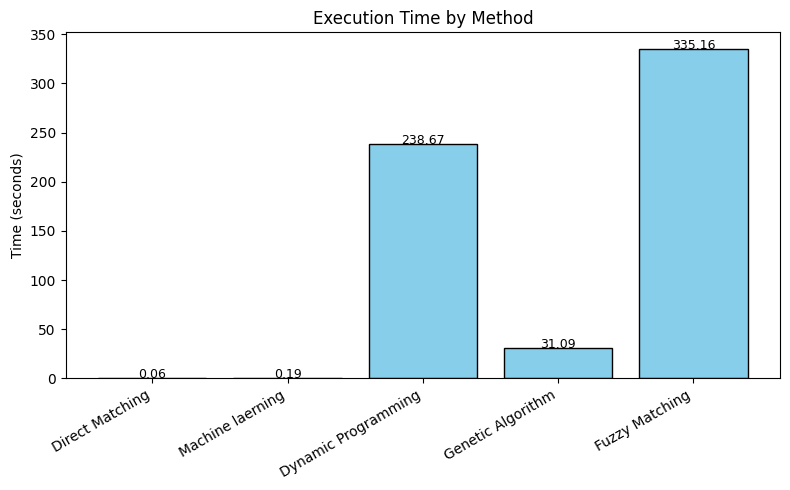

In [210]:
if __name__=="__main__":
  main()